In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from holotomocupy.tomo import R,RT
from holotomocupy.holo import G,GT
from holotomocupy.magnification import M,MT
from holotomocupy.shift import S,ST
from holotomocupy.utils import *
# cp.cuda.set_allocator(cp.cuda.MemoryPool(cp.cuda.malloc_managed).malloc)
%matplotlib inline

np.random.seed(10)

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)


theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
ndist = 4

detector_pixelsize = 3e-6/2
energy = 17.05  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208  # [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3, 1.7065e-3, 2.3975e-3, 3.8320e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//8
show=True
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8  # make multiple of 8
center = ne/2  # rotation axis

## Read real and imaginary parts of the refractive index u = delta+i beta

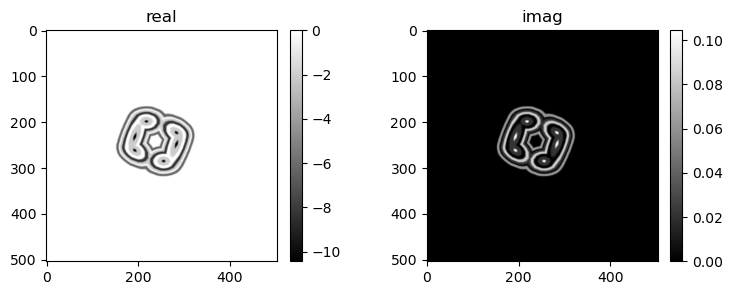

In [ ]:
from scipy import ndimage

cube_all = np.zeros([n, n, n], dtype='float32')
rr = (np.ones(8)*n*0.25).astype(np.int32)
amps = [3, -3, 1, 3, -4, 1, 4]  # , -2, -4, 5 ]
dil = np.array([33, 28, 25, 21, 16, 10, 3])/256*n  # , 6, 3,1]
for kk in range(len(amps)):
    cube = np.zeros([n, n, n], dtype='bool')
    r = rr[kk]
    p1 = n//2-r//2
    p2 = n//2+r//2
    for k in range(3):
        cube = cube.swapaxes(0, k)
        cube[p1:p2, p1, p1] = True
        cube[p1:p2, p1, p2] = True
        cube[p1:p2, p2, p1] = True
        cube[p1:p2, p2, p2] = True
        # cube[p1:p2,p2,p2] = True

    [x, y, z] = np.meshgrid(np.arange(-n//2, n//2),
                            np.arange(-n//2, n//2), np.arange(-n//2, n//2))
    circ = (x**2+y**2+z**2) < dil[kk]**2
    # circ = (x**2<dil[kk]**2)*(y**2<dil[kk]**2)*(z**2<dil[kk]**2)

    fcirc = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(circ)))
    fcube = np.fft.fftshift(np.fft.fftn(
        np.fft.fftshift(cube.astype('float32'))))
    cube = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fcube*fcirc))).real
    cube = cube > 1
    cube_all += amps[kk]*cube

# cube_all = ndimage.rotate(cube_all,52,axes=(1,2),reshape=False,order=1)
cube_all = ndimage.rotate(cube_all, 28, axes=(0, 1), reshape=False, order=3)
cube_all = ndimage.rotate(cube_all, 45, axes=(0, 2), reshape=False, order=3)
cube_all[cube_all < 0] = 0


u0 = cube_all  # (-1*cube_all*1e-6+1j*cube_all*1e-8)/3

u0 = np.roll(u0, -15*n//256, axis=2)
u0 = np.roll(u0, -10*n//256, axis=1)
v = np.arange(-n//2, n//2)/n
[vx, vy, vz] = np.meshgrid(v, v, v)
v = np.exp(-10*(vx**2+vy**2+vz**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(u0)))
u0 = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real
u0[u0 < 0] = 0
u0 = u0*(-1*1e-6+1j*1e-8)*2
u0 = np.pad(u0,((ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)))
!mkdir -p data
np.save(f'data/u{n}', u0)
u = np.array(np.load(f'data/u{n}.npy')).astype('complex64')* voxelsize * 2*np.pi / wavelength*np.sqrt(ne*ntheta) # if already exists
mshow_complex(u[ne//2],show)